In [1]:
# coding: utf-8

# In[1]:

import numpy as np
#import h5py
#import tensorflow as tf
#import matplotlib.pyplot as plt
import tensorflow as tf
import h5py
#from scipy import signal
from tensorflow.python.keras.layers import Input,Conv2D,Concatenate,Flatten,Dense,LeakyReLU,Dropout
from tensorflow.python.keras.callbacks import TensorBoard,ModelCheckpoint
from tensorflow.python.keras.models import Model


from tensorflow.python.keras import backend as K

from tensorflow.python.keras.activations import relu
from tensorflow.python.keras.optimizers import Adam

#from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten
#from tensorflow.python.keras.layers import Conv2D, MaxPooling2D
#from tensorflow.python.keras.models import Sequential

In [2]:
fn = 2
d_min = 1
d_max = 10
blur_filter_size = 11
blur_range = 10
image_size = 256
epochs = 1
batch_size = 28

In [3]:
train_data_path = 'vcm_data/train_data_one_im_norm_2set_256_vcm.npy'
#test_data_path = 'test_data.npy'
train_label_path = 'vcm_data/train_label_one_im_norm_2set_256_vcm.npy'
#test_label_path = 'test_label.npy'

In [4]:
train_data = np.load(train_data_path)
#test_data = np.load(test_data_path)
train_label = np.load(train_label_path)

In [5]:
print(train_data.shape)
print(train_label.shape)

(20000, 256, 256, 1)
(20000, 2)


In [6]:
# In[7]:
input_image1 = Input(shape=(256,256,1))
#layer1_1 = Conv2D(4, (8, 8), 8,padding='valid',activation=None,use_bias=False,kernel_initializer = my_init,trainable=True,name='layer1')(input_image1)
layer1_1 = Conv2D(4, (8, 8), 8,padding='valid',activation=relu)(input_image1)
#layer1_1 = LeakyReLU(0.1)(layer1_1)

layer2_1 = Conv2D(8, (4, 4), 4,padding='valid',activation=relu)(layer1_1)
#layer2_1 = LeakyReLU(0.1)(layer2_1)

layer3_1 = Conv2D(8, (4, 4), 4,padding='valid',activation=relu)(layer2_1)
#layer3_1 = LeakyReLU(0.1)(layer3_1)


flattened = Flatten()(layer3_1)
dense1 = Dense(1024)(flattened)
dense1 = LeakyReLU(0.1)(dense1)
#dense1 = Dropout(0.8)(dense1)

dense2 = Dense(512)(dense1)
dense2 = LeakyReLU(0.1)(dense2)
#dense2 = Dropout(0.5)(dense2)

dense3 = Dense(10)(dense2)
dense3 = LeakyReLU(0.1)(dense3)

output_position = Dense(1)(dense3)
print(output_position)

model = Model(inputs=input_image1, outputs=output_position)




print(model.output_shape)



opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0001)
model.compile(loss='mse', optimizer=opt)

model.fit(train_data[:,:,:,0:1], abs(train_label[:,1:2]-train_label[:,0:1])/100, epochs = epochs,batch_size = batch_size,verbose=1)



#model.save('my_model_step1.h5')

Tensor("dense_3/BiasAdd:0", shape=(?, 1), dtype=float32)
(None, 1)
Epoch 1/1
20000/20000 [==============================] - 5s 229us/step - loss: 1.0240


In [7]:
print(train_label[:, :10])

[[ 800.  500.]
 [ 650.  650.]
 [ 600.  600.]
 ...
 [ 650.  475.]
 [ 725. 1000.]
 [ 475.  875.]]


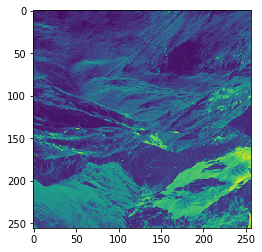

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(train_data[1, :, :, 0])

In [10]:
from tensorflow.python.keras.models import load_model
model = load_model('my_model_step1.h5')

In [12]:
model.predict(train_data[1:2, :, :, :1])

array([[-0.04241865]], dtype=float32)